In [1]:
from m3l.structure import System as sys
import json
#
system = sys()
system.loadSystem('system_Ar_mc.json')
system.convertUnits()
system.save('system_au.json')
#system.convertUnitsInv()
#system.atoms

In [2]:
0.238/system.ECONV

np.float64(0.0003794451213976496)

In [3]:
# definindo o modelo de interação entre os átomos (campo de força)
from m3l.molecular_dynamics import ForceField
class Forces(ForceField):
    def __init__(self):
        super().__init__()
        self.parameters((0.2385/self.ECONV, 3.405/self.ACONV, 10.0/self.ACONV))

model = Forces()

In [4]:
# definindo o modelo estatístico (ensemble)
from m3l.statistics import MonteCarlo as mc
#
temperature = 84.4
temperature = temperature/system.TEMPCONV
pressure = 1000.0
pressure = pressure/system.PCONV
drmax=1.0/system.ACONV
dvmax=0.0/system.ACONV**3
force_field = model()
monte_carlo = mc(temperature, pressure, drmax, dvmax, force_field, nadjst = 500)
system = monte_carlo(system)
#print(system.epotential, tmp.epotential)

In [5]:
# executando looping
import time
import csv
#
n_steps = 100000
output = []
drmax = []
indx = 0
start = time.time()
with open('history.csv', 'w', newline = '') as csvfile1, open('thermodynamics.csv', 'w', newline = '') as csvfile2:
    fieldnames1 = ['x', 'y', 'z']
    writer1 = csv.DictWriter(csvfile1, fieldnames = fieldnames1)
    writer1.writeheader()
    fieldnames2 = ['step', 'energy', 'volume']
    writer2 = csv.DictWriter(csvfile2, fieldnames = fieldnames2)
    writer2.writeheader()
    for step in range(n_steps):
        chk1 = monte_carlo.naccpt
        system = monte_carlo(system)
        chk2 = monte_carlo.naccpt
        drmax.append(monte_carlo.drmax)
        if chk2 != chk1:
            volume = system.cell[0]*system.cell[1]*system.cell[2]
            volume = volume*system.ACONV**3
            energy = system.epotential*system.ECONV
            writer2.writerow({
                'step': step,
                'energy': energy,
                'volume': volume})
            for atom in system.atoms:
                writer1.writerow({
                    'x': atom[1]*system.ACONV,
                    'y': atom[2]*system.ACONV,
                    'z': atom[3]*system.ACONV})
            output.append([energy, volume])
            indx += 1
#        print(f'i: {step}; energy: {system.energy*system.ECONV}')
end = time.time()
print(f'Elapsed time: {end - start}')
print(f'i_step:', indx)

Elapsed time: 455.2294292449951
i_step: 31637


Text(0, 0.5, 'drmax')

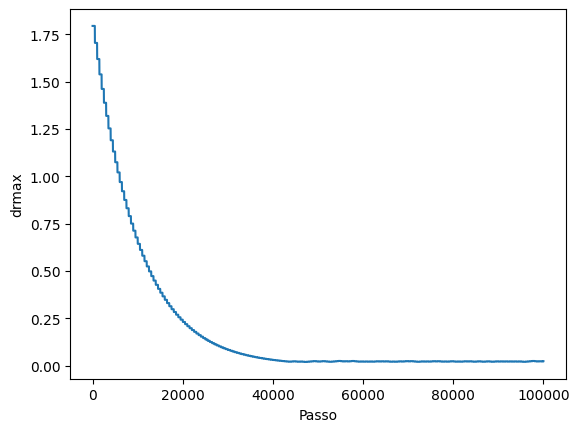

In [6]:
# 
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0, n_steps)
plt.plot(x, drmax)
plt.xlabel('Passo')
plt.ylabel('drmax')

(array([ 215.,  471., 2367., 4007., 7416., 7758., 5410., 2965.,  790.,
         238.]),
 array([-763.23697248, -761.55859224, -759.88021199, -758.20183174,
        -756.52345149, -754.84507124, -753.166691  , -751.48831075,
        -749.8099305 , -748.13155025, -746.45317001]),
 <BarContainer object of 10 artists>)

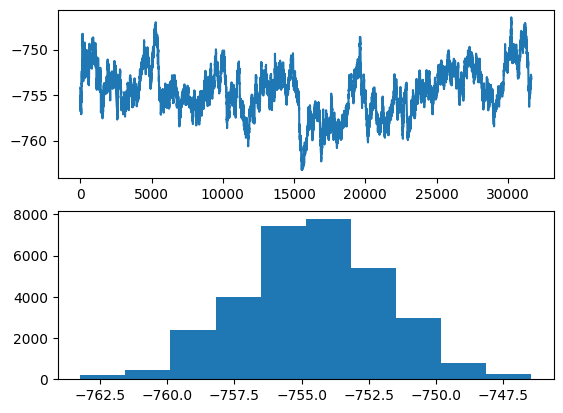

In [7]:
x = np.arange(0, indx)
fig, axs = plt.subplots(2, 1)
data = [item[0] for item in output]
axs[0].plot(x, data)
#axs[0, 0] = plt.ylabel('Energia (kcal/mol)')
#axs[0, 0] = plt.xlabel('Passo')
axs[1].hist(data)
#axs[0, 0] = plt.savefig('monte_carlo.jpg')

(array([    0.,     0.,     0.,     0.,     0., 31637.,     0.,     0.,
            0.,     0.]),
 array([11390.12417439, 11390.22417439, 11390.32417439, 11390.42417439,
        11390.52417439, 11390.62417439, 11390.72417439, 11390.82417439,
        11390.92417439, 11391.02417439, 11391.12417439]),
 <BarContainer object of 10 artists>)

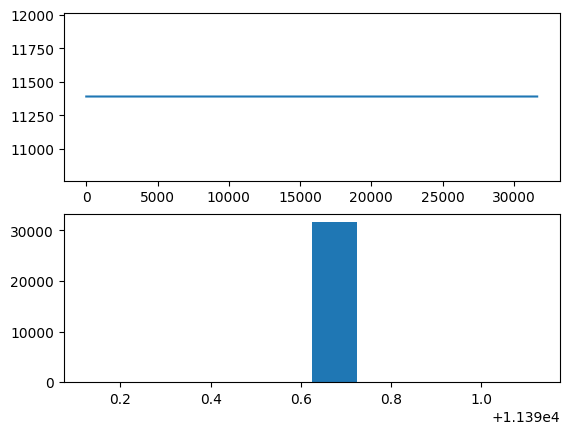

In [8]:
fig, axis = plt.subplots(2, 1)
data = [item[1] for item in output]
axis[0].plot(x, data)
axis[1].hist(data)

In [9]:
system.convertUnitsInv()
system.save('system_Ar_mc.json')